In [1]:
import pandas as pd

In [2]:
url = "https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/features.txt"

feature_name_df = pd.read_csv(url, sep='\s+', header=None, names=['column_index', 'column_name'])
feature_name = feature_name_df.iloc[:,1].values.tolist()

In [3]:
X_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/X_train.txt'
X_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/X_test.txt'

X_train = pd.read_csv(X_train_url, sep='\s+', header=None)
X_test = pd.read_csv(X_test_url, sep='\s+', header=None)

In [4]:
X_train.columns = feature_name
X_test.columns = feature_name

In [5]:
y_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/y_train.txt'
y_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/y_test.txt'

y_train = pd.read_csv(y_train_url, sep='\s+', header=None, names=['action'])
y_test = pd.read_csv(y_test_url, sep='\s+', header=None, names=['action'])

In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352, 1), (2947, 1))

In [7]:
from sklearn.decomposition import PCA

def get_pca_data(ss_data, n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(ss_data)
    
    return pca.transform(ss_data), pca

In [8]:
HAR_pca, pca = get_pca_data(X_train, n_components=2)
HAR_pca.shape

(7352, 2)

In [9]:
pca.mean_.shape, pca.components_.shape

((561,), (2, 561))

In [10]:
cols = ['pca_' + str(n) for n in range(pca.components_.shape[0])]
cols

['pca_0', 'pca_1']

##### PCA 결과를 저장하는 함수

In [11]:
def get_pd_from_pca(pca_data, col_num):
    cols = ['pca_' + str(n) for n in range(col_num)]
    return pd.DataFrame(pca_data, columns=cols)

In [12]:
HAR_pca, pca = get_pca_data(X_train, n_components=2)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train
HAR_pd_pca.head()

,pca_0,pca_1,action
0,-5.520280,-0.290278,5
1,-5.535350,-0.082530,5
2,-5.474988,0.287387,5
3,-5.677232,0.897031,5
4,-5.748749,1.162952,5


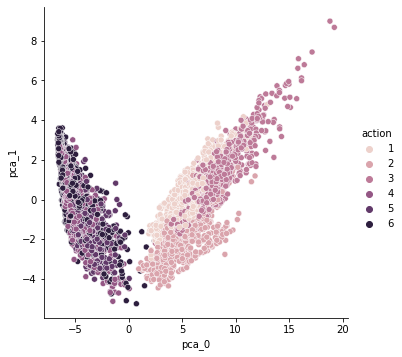

In [13]:
import seaborn as sns

sns.pairplot(HAR_pd_pca, hue='action', height=5, x_vars=['pca_0'], y_vars=['pca_1']);

In [14]:
import numpy as np

def print_variance_ratio(pca):
    print('variance_ratio : ', pca.explained_variance_ratio_)
    print('sum of variance_ratio : ', np.sum(pca.explained_variance_ratio_))
    
print_variance_ratio(pca)

variance_ratio :  [0.6255444  0.04913023]
sum of variance_ratio :  0.6746746270487953


##### components 3개

In [15]:
HAR_pca, pca = get_pca_data(X_train, n_components=3)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train

print_variance_ratio(pca)

variance_ratio :  [0.6255444  0.04913023 0.04121467]
sum of variance_ratio :  0.7158893015785881


##### components 10개

In [16]:
HAR_pca, pca = get_pca_data(X_train, n_components=10)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train

print_variance_ratio(pca)

variance_ratio :  [0.6255444  0.04913023 0.04121467 0.01874956 0.0169486  0.01272069
 0.01176685 0.01068973 0.0096938  0.00858018]
sum of variance_ratio :  0.805038711185584


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {
    'max_depth' : [6, 8, 10],
    'n_estimators' : [50, 100, 200],
    'min_samples_leaf' : [8, 12],
    'min_samples_split' : [8, 12]
}

rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1) # n_jobs -> cpu 코어 몇개를 사용할 지 (-1은 전부 사용)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(HAR_pca, y_train.values.reshape(-1,))

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=13),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10], 'min_samples_leaf': [8, 12],
                         'min_samples_split': [8, 12],
                         'n_estimators': [50, 100, 200]})

In [18]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
target_col = ['rank_test_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth']
cv_results_df[target_col].sort_values('rank_test_score').head()

,rank_test_score,mean_test_score,param_n_estimators,param_max_depth
17,1,0.838003,200,8
14,1,0.838003,200,8
29,3,0.837731,200,10
26,3,0.837731,200,10
32,5,0.837051,200,10


In [19]:
grid_cv.best_params_

{'max_depth': 8,
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'n_estimators': 200}

In [20]:
grid_cv.best_score_

0.8380032644178455

In [21]:
from sklearn.metrics import accuracy_score
rf_clf_best = grid_cv.best_estimator_
rf_clf_best.fit(HAR_pca, y_train.values.reshape(-1,))

pred1 = rf_clf_best.predict(pca.transform(X_test))

accuracy_score(y_test, pred1)

0.8517136070580251

In [22]:
pip install xgboost==0.90

Active code page: 65001
Note: you may need to restart the kernel to use updated packages.


In [23]:
import time
from xgboost import XGBClassifier

evals = [(pca.transform(X_test), y_test)]

start_time = time.time()
xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb.fit(HAR_pca, y_train.values.reshape(-1,), early_stopping_rounds=10, eval_set=evals)
print('Fit time : ', time.time() - start_time)

[0]	validation_0-merror:0.225314
Will train until validation_0-merror hasn't improved in 10 rounds.


C:\Anaconda3\envs\ds_study\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-merror:0.221921
[2]	validation_0-merror:0.204615
[3]	validation_0-merror:0.203936
[4]	validation_0-merror:0.2019
[5]	validation_0-merror:0.202579
[6]	validation_0-merror:0.197489
[7]	validation_0-merror:0.198846
[8]	validation_0-merror:0.197489
[9]	validation_0-merror:0.195114
[10]	validation_0-merror:0.194774
[11]	validation_0-merror:0.191381
[12]	validation_0-merror:0.185952
[13]	validation_0-merror:0.183577
[14]	validation_0-merror:0.182219
[15]	validation_0-merror:0.180862
[16]	validation_0-merror:0.180523
[17]	validation_0-merror:0.17679
[18]	validation_0-merror:0.178487
[19]	validation_0-merror:0.17679
[20]	validation_0-merror:0.175772
[21]	validation_0-merror:0.174415
[22]	validation_0-merror:0.175772
[23]	validation_0-merror:0.175433
[24]	validation_0-merror:0.174075
[25]	validation_0-merror:0.174754
[26]	validation_0-merror:0.173057
[27]	validation_0-merror:0.172379
[28]	validation_0-merror:0.172379
[29]	validation_0-merror:0.169664
[30]	validation_0-merror:0.

In [24]:
accuracy_score(y_test, xgb.predict(pca.transform(X_test)))

0.8673227010519172